In [59]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline
import requests

In [2]:
# Read dataset
url = 'https://raw.githubusercontent.com/karpathy/makemore/master/names.txt'
content_in_bytes = requests.get(url).content
words = content_in_bytes.decode('utf-8').split()

In [3]:
words[:8], len(words)

(['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia'],
 32033)

In [4]:
# Now we create index-mappings from chars to ints and back
chars = set()
for n in words:
    chars_from_name = [i for i in n]
    [chars.add(i) for i in chars_from_name]
chars = sorted(list(chars))
# char to index
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
# {".": 0, "a": 1, etc}
# index to str
itos = {s:i for i,s in stoi.items()}
# {0: ".", 1: "a", etc}
vocab_size = len(itos)

In [5]:
vocab_size

27

In [9]:
block_size = 3

def build_dataset(words: list[str], context_length: int = 3):

    X, Y = [], []

    for w in words:
        context = [0] * block_size
        # we want context to grow with every char
        for char in w + '.':
            prev_chars = context
            target = char
            X.append(prev_chars)
            Y.append(stoi[target])
            idx_char = stoi[char]
            context = context[1:] + [idx_char]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

In [10]:
random.seed(42)
random.shuffle(words)

In [117]:
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

In [12]:
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

In [102]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

12097


In [103]:
max_steps = 200000
batch_size = 32
lossi= []

for i in range(max_steps):
    # mini batch
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

    # forward pass
    emb = C[Xb] # embed characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concat vectors
    hpreact = embcat @ W1 #+ b1 # hidden layer pre activate
    
    # Now we apply batch normalization 
    # Note the gamma (scale) and beta (shift) parameters
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 #output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 10000 else 0.01 # rate decay
    #lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    # track
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d} : {loss.item():.4f}')
    lossi.append(loss.log10().item())
    

      0/ 200000 : 3.3239
  10000/ 200000 : 2.0552
  20000/ 200000 : 2.5275
  30000/ 200000 : 2.0640
  40000/ 200000 : 2.1711
  50000/ 200000 : 1.8003
  60000/ 200000 : 2.0500
  70000/ 200000 : 2.3375
  80000/ 200000 : 2.4105
  90000/ 200000 : 2.0414
 100000/ 200000 : 2.2012
 110000/ 200000 : 2.3800
 120000/ 200000 : 1.6511
 130000/ 200000 : 1.9043
 140000/ 200000 : 2.2341
 150000/ 200000 : 2.0177
 160000/ 200000 : 2.1270
 170000/ 200000 : 2.4877
 180000/ 200000 : 2.0927
 190000/ 200000 : 2.1032


In [88]:
logits[0]

tensor([ 3.1801,  2.2540,  0.5288, -0.2217, -0.0739,  0.1614, -1.6810, -2.6119,
         0.3730,  0.8168, -1.6224, -0.3520,  1.5958,  1.6607,  0.7246,  0.9960,
        -0.4273, -1.9076,  1.4731,  0.5858,  0.9810, -0.2363, -0.4595, -2.2205,
        -2.3000, -0.3829, -0.0224], grad_fn=<SelectBackward0>)

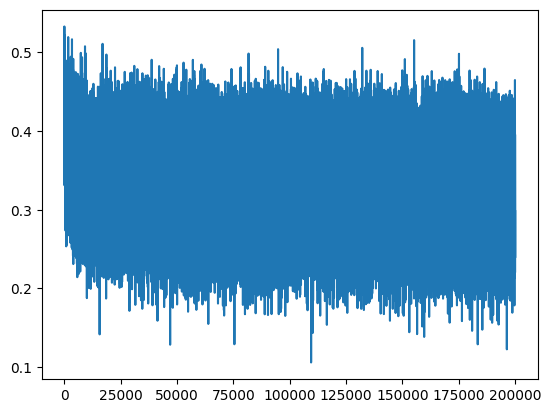

In [104]:
plt.plot(lossi)

In [99]:
# calibrate the batch norm at the end of training
# not needed since we do momentum based norm
with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


In [105]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 + b1
  #hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  #hpreact = bngain * (hpreact - bnmean) / bnstd + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')
split_loss('test')

train 2.1004016399383545
val 2.130575180053711
test 2.1303560733795166


In [70]:
# sample from model
g = torch.Generator().manual_seed(2147483647) # for reproducibility

for _ in range(10):
    out = []
    context = [0] * block_size
    while True:
        # forward pass
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        # shift context window
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample '.', break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) # decode and print generated word

cexzm.
zoglkurkicczktyhwbvlzimjttainrlkfukzkktda.
rfcxvpubjtbhrmgotzx.
iczixqctvujkwptedogkkjemkmmsidgu.
nkbvgynywftbspmhwcivgbvtahlvsu.
dsdxxblnwglhpyiw.
igwnjwbpfdwipkwzkm.
desu.
firmt.
gbiksjbquabsvoth.


## Lecture 3

First improvement is initial values. They are random, hence network is confidently wrong.
We should expect a initial loss of approx 3.29, which is -(log(1/27)), where 1/27 represents the fact that each character is equally likely to be "picked" as the next character. For that, we want W2 and b2 to be close to 0.

In [60]:
# 4d example
logits = torch.tensor([0.,0.,5.,0.])
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss

(tensor([0.0066, 0.0066, 0.9802, 0.0066]), tensor(0.0200))

Other problem is with h (activation layer), it has many 1s and 0s

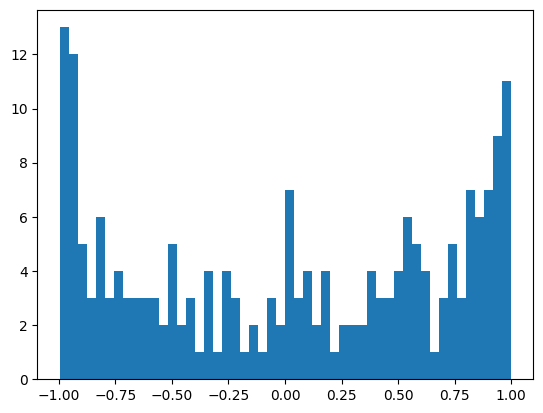

In [71]:
plt.hist(h.view(-1).tolist(),50)
plt.show()

Let's see what's causing this - we see that hpreact is very broad, hence values are very extreme after tanh.

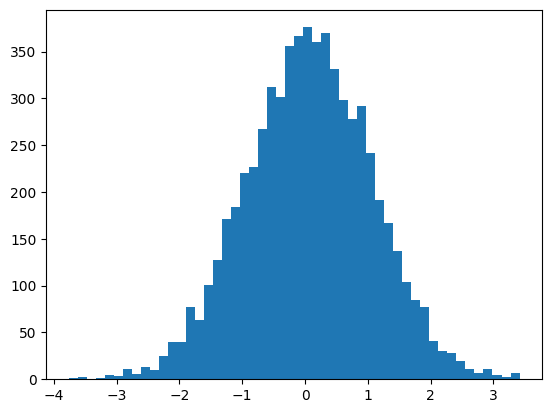

In [72]:
plt.hist(hpreact.view(-1).tolist(),50);

We don't want the tanh to be -1 and 1, because when backproping,the gradient vanishes, because the derivative is (1 - tanh**2) * out.grad, hence the gradient will be killed and update won't get propagated.

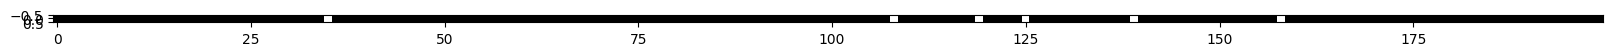

In [77]:
#
plt.figure(figsize=(20,20))
plt.imshow(h.abs()>0.99,cmap='gray', interpolation='nearest')
plt.show()
# if all black, no neurons saturated

In [42]:
# In the above, we look for dead neurons (Columns with all whites), where tanh is 1 everywhere and hence never learns
# because gradient update is 0.

In [43]:
# Idea - implement dogs vs cats from scratch

In [44]:
# Lets see if multiplying matrices by 0.01 improves things

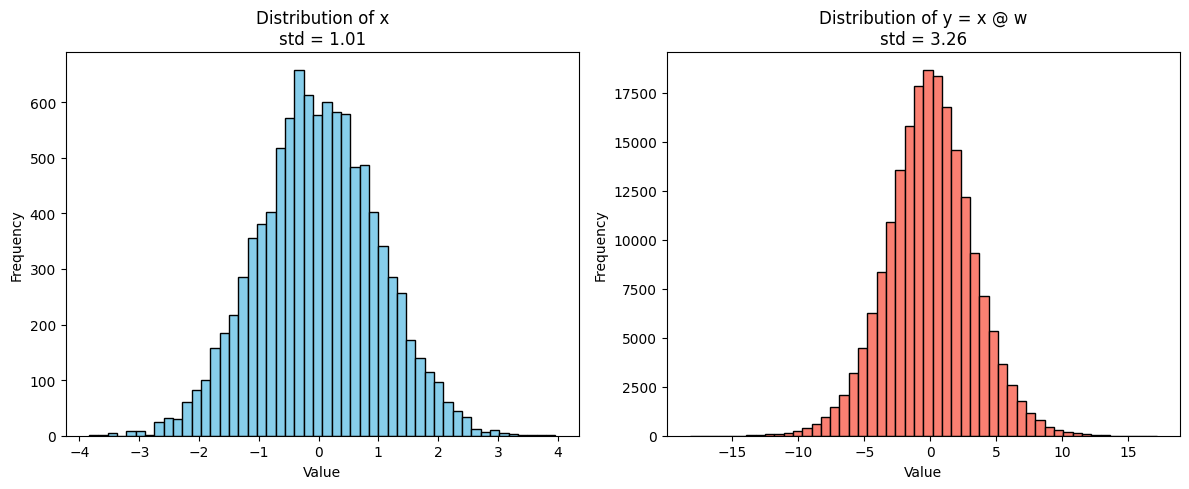

In [24]:
# Now we understand why the stdev on the first actiovation layer increases
import torch
import matplotlib.pyplot as plt
import math

# Generate random data
x = torch.randn(1000, 10)
w = torch.randn(10, 200)
y = x @ w

# Calculate standard deviations
std_x = x.std().item()
std_y = y.std().item()

# Plot histograms
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(x.flatten().numpy(), bins=50, color='skyblue', edgecolor='k')
plt.title(f'Distribution of x\nstd = {std_x:.2f}')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(y.flatten().numpy(), bins=50, color='salmon', edgecolor='k')
plt.title(f'Distribution of y = x @ w\nstd = {std_y:.2f}')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [28]:
x[1].shape

torch.Size([10])

In [26]:
y[0].shape

torch.Size([200])

In [29]:
x.shape

torch.Size([1000, 10])

In [30]:
w.shape

torch.Size([10, 200])

In [45]:
sum1 = 0
for i in range(10):
    sum1 += x[0][i]*w[i][0]

sum1

tensor(4.0344)

In [46]:
y[0][0]

tensor(4.0344)

In [76]:
# From here, we multiply the init matrices with gains (torch init) but they are not incredible important due to Adam optimizers,
# batch normalizations, etc.

In [79]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [81]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [106]:
# Pytorchifying the code

In [119]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

47024


In [120]:
# ToDo - Use Pytorch classes

In [121]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function
  
  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


Text(0.5, 1.0, 'activation distribution')

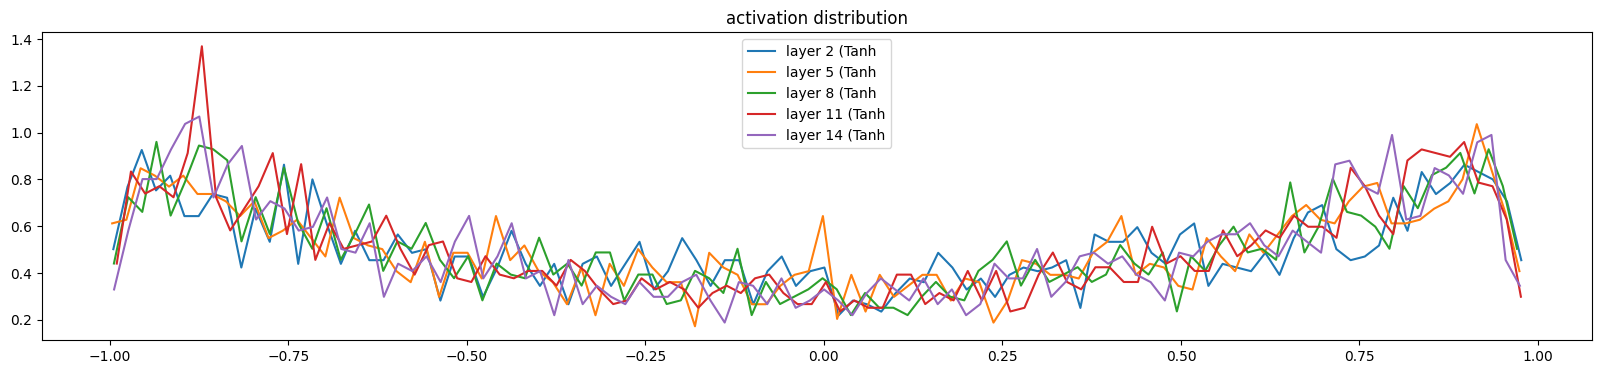

In [ ]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach()) 
    legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('activation distribution')

In [112]:
'''
# What we are trying to do is
1. Make sure tanh is not saturated
2. Make sure that gradients look OK, i.e. not overly expanding nor shrinking

This can be empirically demonstrated by setting incorrect gains (too small, too high)
'''


'\n# What we are trying to do is\n1. Make sure tanh is not saturated\n2. Make sure that gradients look OK, i.e. not overly expanding nor shrinking\n\nThis can be empirically demonstrated by setting incorrect gains (too small, too high)\n'

In [115]:
# Summary
# Batch normalization helps stabilize training
# Pytorchify stuff (to be improved by GF)
# Diagnostics for training (to be understood if something else can be plugged in Pytorch)